# Differentiable Physics VI: Compressible Navier Stokes


We limit the scope of the solver with the following constraints:

- We use the conservative form of the equations, meaning we are looking at a volume which is fixed in space and the fluid is moving through it.
- We use a 2D grid based approach, where each cell in the grid represents a volume element and has size $\Delta x \times \Delta y$.

The following variables are used:

- $\vec{v_{i,j}}$ : velocity with x / y components $u$ and $v$
- $\rho$ : density
- $p$ : pressure
- $E$ : Total energy
- $e$ : internal energy
- $T$ : Temperature
- $\mu$ : viscosity constant
- $k$ : thermal conductivity constant
- $\Delta t$ : time step size
- $\Delta x$ : grid cell size in x direction
- $\Delta y$ : grid cell size in y direction

We can formulate the navier stokes equations for compressible flow as follows:

$$\frac{U}{\Delta t} + \frac{E}{\Delta x} + \frac{F}{\Delta y} = 0$$

where the state vector $U$ and the two fluxes $E$ and $F$ are defined as:

$$
U = \begin{bmatrix} \rho \\ \rho u \\ \rho v \\ E \end{bmatrix} \quad
E = \begin{bmatrix} \rho u \\ \rho u^2 + p - \tau_{xx} \\ \rho u v - \tau_{xy} \\ (E + p) u - u \tau_{xx} - v \tau_{xy} + q_x \end{bmatrix} 
F = \begin{bmatrix} \rho v \\ \rho u v - \tau_{xy} \\ \rho v^2 + p - \tau_{yy} \\ (E + p) v - u \tau_{xy} - v \tau_{yy} + q_y \end{bmatrix} $$

$\tau_{xx}$, $\tau_{xy}$, $\tau_{yy}$ are the components of the viscous stress tensor:

$$ \tau_{xx} = \mu \left( 2 \frac{\partial u}{\partial x} - \frac{2}{3} \left( \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} \right) \right) \quad
\tau_{xy} = \mu \left( \frac{\partial u}{\partial y} + \frac{\partial v}{\partial x} \right) \quad
\tau_{yy} = \mu \left( 2 \frac{\partial v}{\partial y} - \frac{2}{3} \left( \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} \right) \right) $$

and $q_x$, $q_y$ are components of the heat flux vector.

$$ q_x = - \lambda \frac{\partial T}{\partial x} \quad
q_y = - \lambda \frac{\partial T}{\partial y} $$

Finally the following realtions hold:

$$ p = (\gamma - 1) \rho e \quad 
T = \frac{(\gamma - 1)e}{R}$$

where $R$ is the gas constant and $\gamma$ is the ratio of specific heats. For air we have $R = 287 m^2/(s^2 K)$ and $\gamma$ = 1.4. 


We now insert the navier stokes equations into the mac cormack method. We start with the predictor step:

$$\bar{U}_{i,j}^{n+1} = U_{i,j}^n - \frac{\Delta t}{\Delta x} \left( E_{i+1, j}^{n} - E_{i, j}^{n} \right) - \frac{\Delta t}{\Delta y} \left( F_{i, j+1}^{n} - F_{i, j}^{n} \right)$$

and the corrector step:

$$U_{i,j}^{n+1} = \frac{1}{2} \left[ \left( U_{i,j}^n + \bar{U}_{i,j}^{n+1} \right) - \frac{\Delta t}{ \Delta x} \left( \bar{E}_{i, j}^{n+1} - \bar{E}_{i-1, j}^{n+1} \right) - \frac{\Delta t}{\Delta y} \left( \bar{F}_{i, j}^{n+1} - \bar{F}_{i, j-1}^{n+1} \right) \right]$$

In [14]:
import jax.numpy as jnp
from jax import value_and_grad, jit
from functools import partial

@partial(jit, static_argnames=("delta", "axis"))
def fd(f : jnp.ndarray, delta : float, axis : int):
    return jnp.roll(f, -1, axis=axis) - f / delta

@partial(jit, static_argnames=("delta", "axis"))
def bd(f : jnp.ndarray, delta : float, axis : int):
    return f - jnp.roll(f, 1, axis=axis) / delta

@partial(jit, static_argnames=("delta", "axis"))
def cf(f : jnp.ndarray, delta : float, axis : int):
    return (jnp.roll(f, -1, axis=axis) - jnp.roll(f, 1, axis=0)) / (2*delta)

In [15]:
from jax.tree_util import Partial

# U : [rho, rho*u, rho*v, E_total]
@partial(jit, static_argnames=("dx", "dy", "mu", "gamma", "R", "k", "derivation_schema"))
def unpack(
    U : jnp.ndarray, # state vector
    dx : float, # delta x
    dy : float, # delta y
    mu : float, # viscosity
    gamma : float, #
    R : float, # gas constant
    k : float, # thermal conductivity
    derivation_schema : tuple[str, str] # schema for the derivation of the spatial derivatives	
) -> tuple[jnp.ndarray, jnp.ndarray]:
    """"
    Solver step for the compressible Stokes equations in 2D using the finite difference method along with the Mac Cormack method.
    """
    d_dx = Partial(fd, delta=dx, axis=0) if derivation_schema[0] == 'f' else Partial(bd, delta=dx, axis=0)
    d_dy = Partial(fd, delta=dy, axis=1) if derivation_schema[1] == 'f' else Partial(bd, delta=dy, axis=1)

    # unpack state vector
    rho = U[:,:,0] # density
    u = U[:,:,1]/rho # velocity in x direction
    v = U[:,:,2]/rho # velocity in y direction
    e = U[:,:,3]/rho - 0.5*(u**2 + v**2) # internal energy
    T = (gamma - 1)*e / R # temperature
    p = (gamma - 1)*rho*e # pressure

    # viscous stress tensors
    tau_xx = 2/3*mu*(2*d_dx(u) - d_dy(v))
    tau_yy = 2/3*mu*(2*d_dy(v) - d_dx(u))
    tau_xy = mu*(d_dx(u) + d_dy(v))

    # heat flux
    q_x = -k*d_dx(T)
    q_y = -k*d_dy(T)

    E = jnp.zeros_like(U)
    F = jnp.zeros_like(U)

    rhou = rho * u
    rhov = rho * v
    rhouv = rhou * v

    E = E.at[:,:,0].set(rhou) # continuity equation
    E = E.at[:,:,1].set(rho * u ** 2 + p - tau_xx) # momentum equation
    E = E.at[:,:,2].set(rhouv - tau_xy) # momentum equation
    E = E.at[:,:,3].set((U[:,:,3] + p) * u - u * tau_xx - v * tau_xy + q_x) # energy equation

    F = F.at[:,:,0].set(rhov) # continuity equation
    F = F.at[:,:,1].set(rhouv - tau_xy) # momentum equation
    F = F.at[:,:,2].set(rho *v ** 2 + p - tau_yy) # momentum equation
    F = F.at[:,:,3].set((U[:,:,3] + p) * v - u*tau_xy - v * tau_yy + q_y) # energy equation

    return E, F

In [16]:
@partial(jit, static_argnames=("dt", "dx", "dy", "mu", "gamma", "R", "k", "pred_scheme", "corr_scheme"))
def mac_cormack_2d(
    U : jnp.ndarray, # state vector
    dt : float, # delta time
    dx : float, # delta x
    dy : float, # delta y
    mu : float, # viscosity
    gamma : float, # ratio of specific heats
    R : float, # gas constant
    k : float, # thermal conductivity
    pred_scheme : tuple[str, str],
    corr_scheme : tuple[str, str]
) -> jnp.ndarray:
    
    pd_dx = Partial(fd, delta=dx, axis=0) if pred_scheme[0] == 'f' else Partial(bd, delta=dx, axis=0)
    pd_dy = Partial(fd, delta=dy, axis=1) if pred_scheme[1] == 'f' else Partial(bd, delta=dy, axis=1)

    cd_dx = Partial(fd, delta=dx, axis=0) if corr_scheme[0] == 'f' else Partial(bd, delta=dx, axis=0)
    cd_dy = Partial(fd, delta=dy, axis=1) if corr_scheme[1] == 'f' else Partial(bd, delta=dy, axis=1)

    E, F = unpack(U, dx, dy, mu, gamma, R, k, pred_scheme)

    U_pred = U - \
        dt * pd_dx(E) - \
        dt * pd_dy(F)
    
    E_pred, F_pred = unpack(U_pred, dx, dy, mu, gamma, R, k, corr_scheme)

    U_fwd = 1/2 * ( (U + U_pred) - \
        dt * cd_dx(E_pred) - \
        dt * cd_dy(F_pred) )
        

    return U_fwd

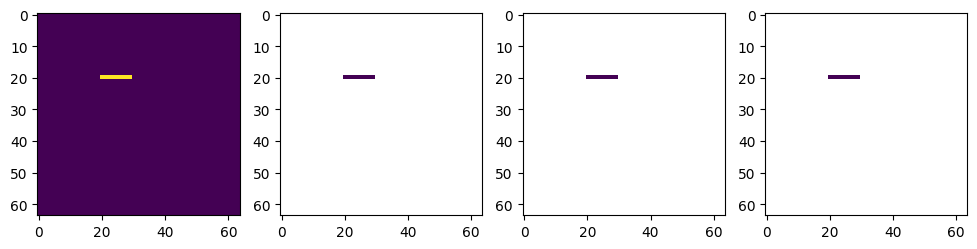

In [32]:
from jax import random
import matplotlib.pyplot as plt

grid_size = 64

U = jnp.zeros((grid_size, grid_size, 4))
U = U.at[:, :, 0].set(1.0)
U = U.at[:, :, 3].set(1.0)
U = U.at[20,20:30,1].set(10.0)

dt = 0.003
dx = 1.0
dy = 1.0
mu = 1.0
gamma = 1.4
R = 100
k = 1.0

fig, axs = plt.subplots(1, 4, figsize=(12, 3))

pred_schemes = [
    ('f', 'f'),
    ('b', 'b'),
    ('f', 'b'),
    ('b', 'f')
]

corr_schemes = [
    ('b', 'b'),
    ('f', 'f'),
    ('b', 'f'),
    ('f', 'b')
]

iteration = 0
for i in range(4):

    axs[i].imshow(U[:,:,1])

    for _ in range(100):
        iteration += 1
        U = mac_cormack_2d(
            U, dt, dx, dy, 
            mu, gamma, R, k,
            pred_schemes[iteration % 4], 
            corr_schemes[iteration % 4]
        )
        U = U.at[20,20:30,1].set(10.0)